# Analysing ultrasound beacons in the wild

In [1]:
from scipy.io.wavfile import read as wavread
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import hilbert 
from scipy.signal import argrelextrema

## Let's open the signal

In [2]:
audiofilename = "ajami.wav"
[samplerate, x] = wavread(audiofilename) # x is a numpy array of integer, representing the samples 
# scale to -1.0 -- 1.0
if x.dtype == 'int16':
    nb_bits = 16 # -> 16-bit wav files
elif x.dtype == 'int32':
    nb_bits = 32 # -> 32-bit wav files
max_nb_bit = float(2 ** (nb_bits - 1))
samples = x / (max_nb_bit + 1.0) # samples is a numpy array of float representing the samples 

## Let's plot the signal

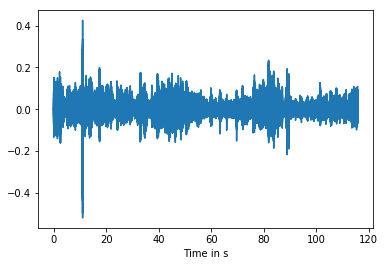

In [3]:
t = range(len(x))
for k in range(len(x)):
    t[k] = 1.0*t[k] / samplerate
plt.plot(t,samples)  # let's plot the sound
plt.xlabel("Time in s")
plt.show()

#### FFT analysis


In [4]:
L = len(x)
F1 = 20000
F2 = 20050

f1 = int(F1*L/samplerate)
f2 = int(F2*L/samplerate)

f = range(len(x))
for k in range(len(x)):
    f[k] = 1.0e-3*f[k]*samplerate/len(x)

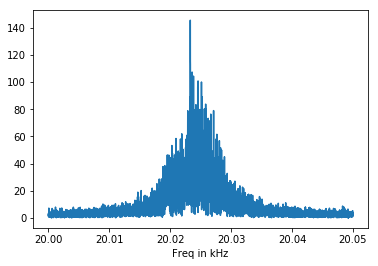

In [18]:
# Let's get the signal around 20khz:
A = np.fft.fft(samples)


plt.plot(f[f1:f2],np.abs(A)[f1:f2])  
plt.xlabel("Freq in kHz")
plt.show()

#### We observe a peak at 20khz, with symetrical peaks around - right what we were looking for !


Length of an acq: 85ms
681


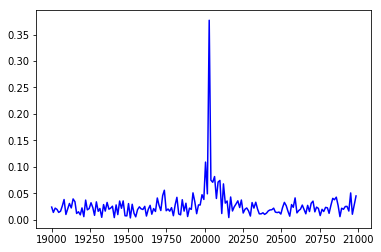

In [52]:
T = 4*1024
d = 200000

print "Length of an acq: "+str(1000*T/samplerate)+"ms"
nS = int(L/T)
print nS/2+2


F1 = 19000
F2 = 21000

d1 = int(F1*T/samplerate)
d2 = int(F2*T/samplerate)

tdet = range(d2-d1)
for i in range(d2-d1):
    tdet[i] = F1 + i*(F2-F1)/(d2-d1)
    
B = np.abs(np.fft.fft(samples[d:d+T]))

plt.plot(tdet,B[d1:d2],"b")   
#plt.axvline(x=d1, color='r', linestyle='-')
#plt.axvline(x=d2, color='r', linestyle='-')
plt.show() 

In [53]:
SP = []
for i in range(nS):
    B = np.fft.fft(samples[i*T:(i+1)*T-1])
    SP.append(np.abs(B[d1:d2]))  
SPP = np.asarray(SP)

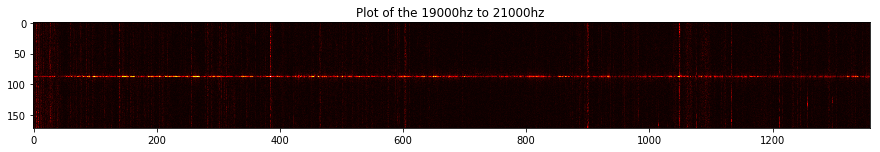

In [54]:
m1 = 0
m2 = L
xl = range(d2-d1)
yl = range(m2-m1)
plt.figure(figsize=(15,5))

plt.imshow(np.transpose(SPP[m1:m2]), cmap='hot',vmin=SPP.min(),vmax=SPP.max()) 
plt.title("Plot of the "+str(F1)+"hz to "+str(F2)+"hz ")
plt.show()

* Seems like peaks at 20khz, with ripples at +- 250hz
* See https://www.sec.cs.tu-bs.de/pubs/2016-batmobile.pdf

In [19]:
C = A
m = abs( np.average(A[int(0.9*f1):f1]) ) 
for k in range(len(A)/2+1):
    if k < int(0.9*f1) or k > int(1.1*f2):
        C[k] = 0
        C[-k] = 0 
print m
Cleaned = np.real( np.fft.ifft(C) )

0.00572274549415


In [125]:
def USGet(wavfilename,F1,F2):
    
    audiofilename = wavfilename
    [samplerate, x] = wavread(audiofilename) # x is a numpy array of integer, representing the samples 
    # scale to -1.0 -- 1.0
    if x.dtype == 'int16':
        nb_bits = 16 # -> 16-bit wav files
    elif x.dtype == 'int32':
        nb_bits = 32 # -> 32-bit wav files
    max_nb_bit = float(2 ** (nb_bits - 1))
    samples = x / (max_nb_bit + 1.0) # samples is a numpy array of float representing the samples 


    d1 = int(F1*len(x)/samplerate)
    d2 = int(F2*len(x)/samplerate)

    f = range(len(x))
    for k in range(len(x)):
        f[k] = 1.0e-3*f[k]*samplerate/len(x)
        
    A = np.fft.fft(samples)
    plt.plot(f[d1:d2],np.abs(A)[d1:d2])  
    plt.savefig(wavfilename+'-1.png')
    plt.xlabel("Frequency in kHz")
    plt.title("Overall spectrum of the file: "+wavfilename+".")
    plt.show() 
    
    
    T = 4*1024
    nS = int(L/T)
    dd1 = int(F1*T/samplerate)
    dd2 = int(F2*T/samplerate)

    SP = []
    RawSP = []
    for i in range(nS):
        B = np.fft.fft(samples[i*T:(i+1)*T-1])
        
        B = B / (np.average(np.abs(B[dd1:dd1+60])) + np.average(np.abs(B[dd1+100:dd1+160])) )
        SP.append(np.abs(B[dd1:dd2]))  
        RawSP.append( np.concatenate((B[dd1:dd2], B[T-dd2:T-dd1]), axis=0))
    SPP = np.asarray(SP)

    plt.figure(figsize=(15,5))
    plt.imshow(np.transpose(SPP[m1:m2]), cmap='hot',vmin=SPP.min(),vmax=SPP.max()) 
    plt.title("Plot of the "+str(F1/1000)+"kHz to "+str(F2/1000)+"kHz ("+audiofilename+")")
    plt.savefig(wavfilename+'-2.png')
    plt.show()

    return RawSP,dd1,dd2,T

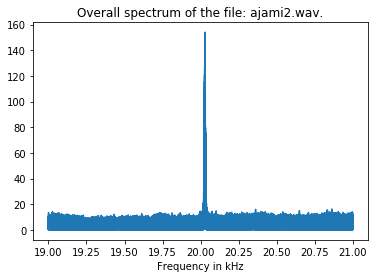

In [ ]:
spp,dd1,dd2,T = USGet("ajami2.wav",19000,21000)